# Pitching Fantasy MVP

### MSP 9.24.2017

Goals:


In [ ]:
from IPython.display import HTML
HTML('''<script>code_show=true; function code_toggle() { if (code_show){ $('div.input').hide();} else { $('div.input').show(); } code_show = !code_show} $( document ).ready(code_toggle);</script><form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [1]:
# boilerplate imports

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

import matplotlib as mpl



In [2]:
# imports for scraping

from bs4 import BeautifulSoup
import requests


# basic birth year reader. tables[1] has good stuff in it!
def get_birth_year(tables):

    birthdate_start = (tables[1].text).find("Birthdate:")

    birthdate_end =  (tables[1].text).find('(',birthdate_start)

    #print (tables[1].text)[birthdate_start:birthdate_end]
    birth_year = (tables[1].text)[birthdate_start:birthdate_end].split('/')[2]
    #print birth_year
    
    return birth_year





#### Compile Hitters

This cell only needs to be run in the event that player ID numbers change, or new players are added.

In [3]:

HDict = {}

f = open('data/pitcherdict.dat')

for line in f:
    #print line
    try:
        HDict[(line.split('|')[0]).strip()] = line.split('|')[1]
    except:
        pass
    
    
print('Found {} hitters by scraping teams.'.format(len(HDict.keys())))

Found 648 hitters by scraping teams.


### Grab Game Logs

Get the following quantities:
1. Hits
2. Walks
3. Strikeouts

In [5]:
#
# for an individual player
#'

itable = [u'Date', u'Team', u'Opp', u'GS', u'W', u'L', u'SV', \
          u'HLD', u'IP', u'TBF', u'H', u'R', u'ER', u'HR', \
          u'BB', u'SO', u'K/9', u'BB/9', u'HR/9', u'BABIP', u'LOB%', u'GB%', u'HR/FB', \
          u'ERA', u'FIP', u'xFIP', u'GSv2']
#             0         1        2    3     4      5     6  \
#            7      8   9       10    11      12     13  \
#            14    15    16    17          18       19      20     21      22
#           23      24      25       26




plist = ['Corey Kluber','Chris Sale','Max Scherzer','Clayton Kershaw','Kenley Jansen','Craig Kimbrel','Zack Greinke',\
        'Luis Severino','Stephen Strasburg','Carlos Carrasco','Gio Gonzalez']

#plist = HDict.keys()

#for player in HDict.keys():

def obtain_players(plist):
    
    # set up dictionary
    PVals = {}

    pnum = 0

    for player in plist:
        PVals[player] = {}
        #print player,

        get_url = 'http://www.fangraphs.com/statsd.aspx?playerid='+str(HDict[player].strip())
        
        #get_url = 'http://www.fangraphs.com/statsd.aspx?playerid=11836&position=P'
        #print get_url

        r  = requests.get(get_url)

        data = r.text

        soup = BeautifulSoup(data)

        tables = soup.findAll('table')

        birth_year = float(get_birth_year(tables))

        PVals[player]['so'] = []
        PVals[player]['wh'] = []
        PVals[player]['w'] = []
        PVals[player]['er'] = []


        for indx,table in enumerate(tables):

            #print indx,[th.get_text() for th in table.find("tr").find_all("th")]

            if [th.get_text() for th in table.find("tr").find_all("th")] == itable:

                #print get_url
                #if (pnum % 50) == 0:
                #    print pnum,player
                print pnum, player
                
                pnum += 1

                #print [th.get_text() for th in table.find("tr").find_all("th")]

                #print table.find_all("tr", class_="grid_multi")

                for row in table.find_all("tr")[1:]:
                    

                    if (row in table.find_all("tr", class_="grid_postseason")) |\
                        (row in table.find_all("tr", class_="grid_multi")):
                            #print 'Multi and/or Postseason:',sav[0]
                            continue


                    sav = [td.get_text() for td in row.find_all("td")]
                    
                    #print sav
                    
                    #print sav
                
                    
                    if ('Date' not in sav[0]) & ('Total' not in sav[0]) :
                        PVals[player]['so'].append(float(sav[15]))
                        PVals[player]['wh'].append(float(sav[10]) + float(sav[14]))
                        PVals[player]['w'].append(float(sav[4]))
                        PVals[player]['er'].append(float(sav[12]))


                    #if (np.sum([(x.strip() in sav[1]) for x in projections])==0) & \
                    #(np.sum([(x in sav[1]) for x in minors])==0) & \
                    #(np.sum([(x in sav[0]) for x in agg])==0): 
                    #    try:
                    #        PVals[player]['bo'].append(float(sav[0])-birth_year)
                    #        PVals[player]['pos'].append(float(sav[14])/float(sav[4]))
                    #        PVals[player]['bbr'].append(float(sav[12])/float(sav[4]))

                    #    except:
                    #        # this is janky way to skip postseason. please fix this
                    #        #print 'Skipped for postseason',sav[0],sav[1]
                    #        pass

    return PVals


PVals = obtain_players(plist)



0 Corey Kluber
1 Chris Sale
2 Max Scherzer
3 Clayton Kershaw
4 Kenley Jansen
5 Craig Kimbrel
6 Zack Greinke
7 Luis Severino
8 Stephen Strasburg
9 Carlos Carrasco
10 Gio Gonzalez


In [35]:
# check the 'can't hurt zone'


for player in PVals.keys():
    
    print('{0:20s}{1:4d}{2:4d}{3:7.2f}{4:5.0f}{5:5.0f}'.format(player,len(np.where( (np.array(PVals[player]['wh']) <= 4.) & (np.array(PVals[player]['er']) <= 2.))[0]),len(PVals[player]['er']),len(np.where( (np.array(PVals[player]['wh']) <= 6.) & (np.array(PVals[player]['er']) <= 2.))[0])/float(len(PVals[player]['er'])),np.sum(PVals[player]['so']),np.sum(PVals[player]['w'])))


Chris Sale             5  31   0.48  300   17
Corey Kluber           8  27   0.56  252   17
Kenley Jansen         62  63   0.98  105    5
Carlos Carrasco        5  31   0.42  212   17
Luis Severino          5  30   0.40  221   13
Gio Gonzalez           4  30   0.43  179   15
Clayton Kershaw        7  25   0.52  194   17
Max Scherzer           7  29   0.62  253   15
Stephen Strasburg      5  27   0.48  196   14
Craig Kimbrel         64  64   1.00  121    5
Zack Greinke           3  31   0.55  211   17


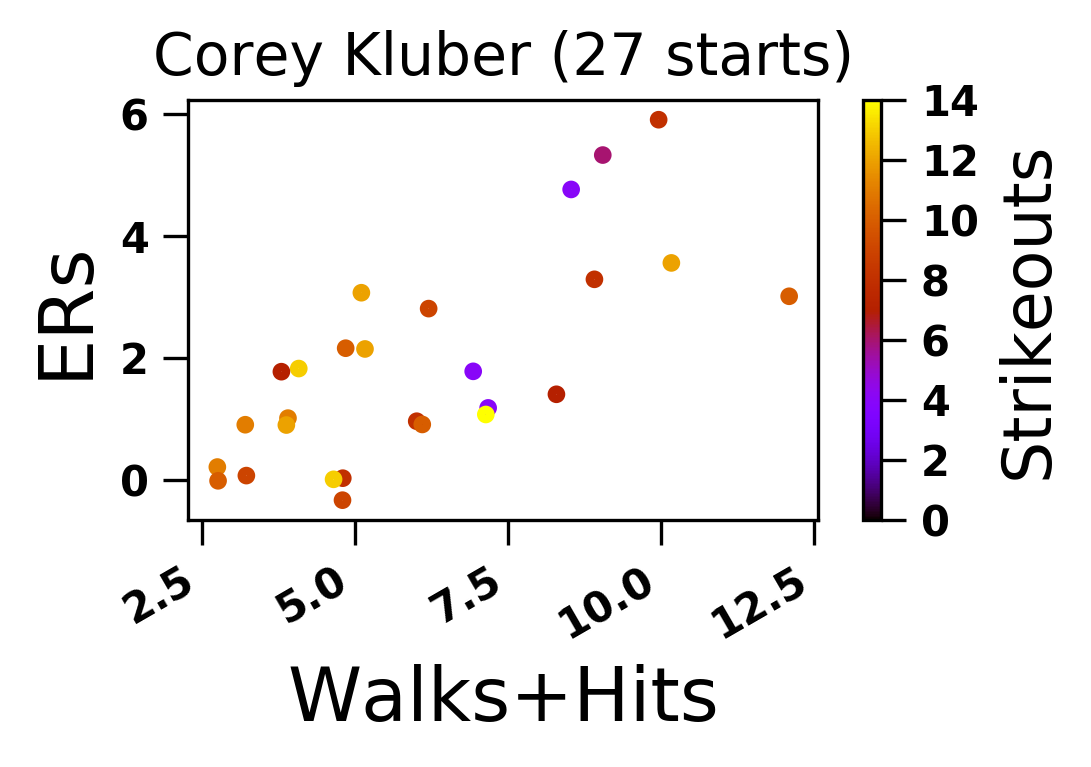

In [6]:
player = 'Corey Kluber'

fig = plt.figure(figsize=(3,2))
ax = fig.add_axes([0.15,0.15,0.7,0.7])
ax2 = fig.add_axes([0.9,0.15,0.02,0.7])

rand_offset = np.array([0.2*np.random.randn() for x in range(0,len(PVals[player]['wh']))])
rand_offset2 = np.array([0.2*np.random.randn() for x in range(0,len(PVals[player]['wh']))])

cbar = ax.scatter(np.array(PVals[player]['wh'])+rand_offset,np.array(PVals[player]['er'])+rand_offset2,lw=2.,\
                  facecolor='none',edgecolor=cm.gnuplot(PVals[player]['so']/np.max(PVals[player]['so']),1.),s=5.)

#ax.plot([0.22,0.38],[0.,0.],color='gray',linestyle='dashed')

#ax.axis([0.22,0.38,-2.5,2.5])
ax.set_xlabel('Walks+Hits',size=18)
ax.set_ylabel('ERs',size=18)
ax.set_title(player+' ('+str(len(PVals[player]['wh']))+' starts)',size=14)

cmap = mpl.cm.gnuplot
norm = mpl.colors.Normalize(vmin=0., vmax=np.max(PVals[player]['so']))
cb1 = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,norm=norm)
cb1.set_label('Strikeouts',size=16)

for label in ax.get_xticklabels(): label.set_rotation(30); label.set_horizontalalignment("right")

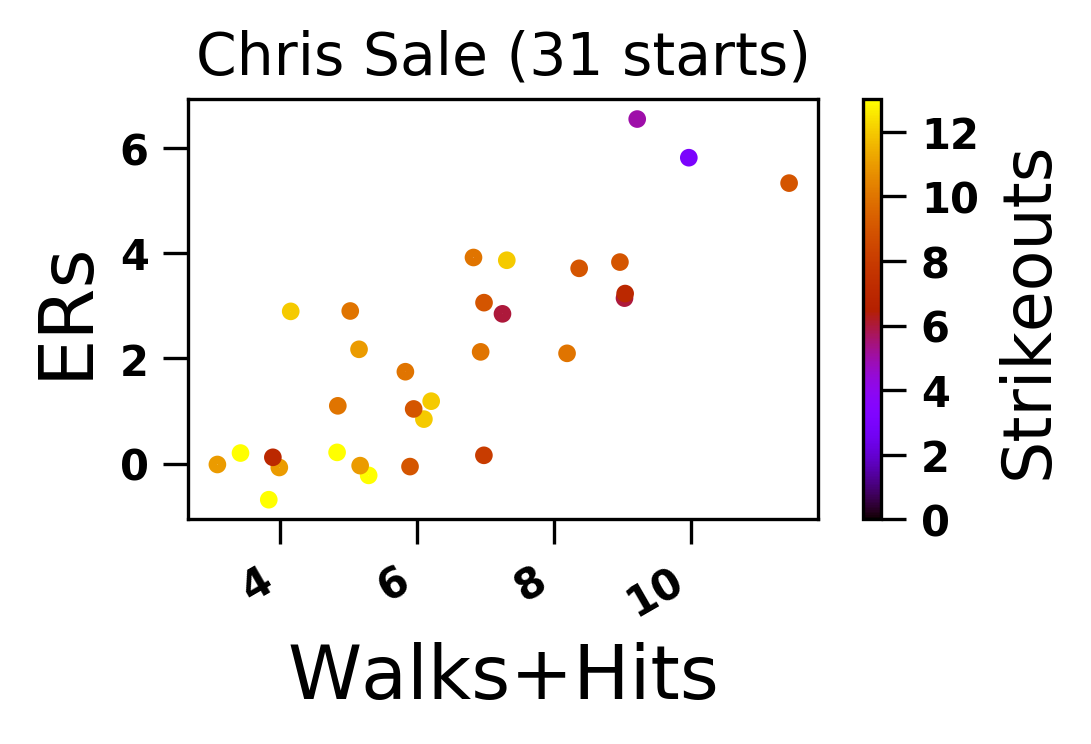

In [7]:
player = 'Chris Sale'

fig = plt.figure(figsize=(3,2))
ax = fig.add_axes([0.15,0.15,0.7,0.7])
ax2 = fig.add_axes([0.9,0.15,0.02,0.7])

rand_offset = np.array([0.2*np.random.randn() for x in range(0,len(PVals[player]['wh']))])
rand_offset2 = np.array([0.2*np.random.randn() for x in range(0,len(PVals[player]['wh']))])

cbar = ax.scatter(np.array(PVals[player]['wh'])+rand_offset,np.array(PVals[player]['er'])+rand_offset2,lw=2.,\
                  facecolor='none',edgecolor=cm.gnuplot(PVals[player]['so']/np.max(PVals[player]['so']),1.),s=5.)

#ax.plot([0.22,0.38],[0.,0.],color='gray',linestyle='dashed')

#ax.axis([0.22,0.38,-2.5,2.5])
ax.set_xlabel('Walks+Hits',size=18)
ax.set_ylabel('ERs',size=18)
ax.set_title(player+' ('+str(len(PVals[player]['wh']))+' starts)',size=14)

cmap = mpl.cm.gnuplot
norm = mpl.colors.Normalize(vmin=0., vmax=np.max(PVals[player]['so']))
cb1 = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,norm=norm)
cb1.set_label('Strikeouts',size=16)

for label in ax.get_xticklabels(): label.set_rotation(30); label.set_horizontalalignment("right")

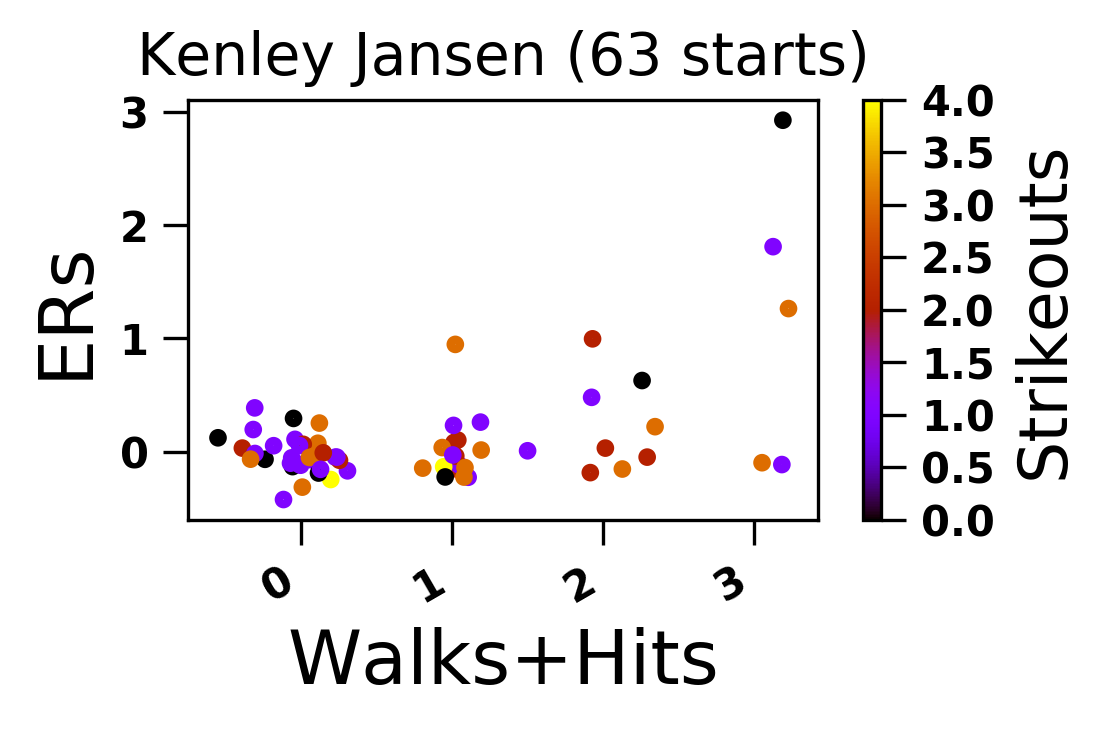

In [8]:
player = 'Kenley Jansen'

fig = plt.figure(figsize=(3,2))
ax = fig.add_axes([0.15,0.15,0.7,0.7])
ax2 = fig.add_axes([0.9,0.15,0.02,0.7])

rand_offset = np.array([0.2*np.random.randn() for x in range(0,len(PVals[player]['wh']))])
rand_offset2 = np.array([0.2*np.random.randn() for x in range(0,len(PVals[player]['wh']))])

cbar = ax.scatter(np.array(PVals[player]['wh'])+rand_offset,np.array(PVals[player]['er'])+rand_offset2,lw=2.,\
                  facecolor='none',edgecolor=cm.gnuplot(PVals[player]['so']/np.max(PVals[player]['so']),1.),s=5.)

#ax.plot([0.22,0.38],[0.,0.],color='gray',linestyle='dashed')

#ax.axis([0.22,0.38,-2.5,2.5])
ax.set_xlabel('Walks+Hits',size=18)
ax.set_ylabel('ERs',size=18)
ax.set_title(player+' ('+str(len(PVals[player]['wh']))+' starts)',size=14)

cmap = mpl.cm.gnuplot
norm = mpl.colors.Normalize(vmin=0., vmax=np.max(PVals[player]['so']))
cb1 = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,norm=norm)
cb1.set_label('Strikeouts',size=16)

for label in ax.get_xticklabels(): label.set_rotation(30); label.set_horizontalalignment("right")

The 'can't hurt you zone', with <=2 ER, <=6 W+H